In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import spacy
import gzip
import json
import plotly.express as px
import plotly.graph_objects as go
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as Sia


#data processing
import re, string
import nltk

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB




#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42



# Load Dataset 1

In [2]:
def parse(path):
    with gzip.open(path, 'rt', encoding='utf-8') as g:
        for l in g:
            yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Specify the correct file path
file_path = 'C:\\Users\\CRANKZ\\OneDrive\\Desktop\\LMJU Masters\\Amazon\\Video_Games_5.json.gz'
df1 = getDF(file_path)



In [3]:
df1.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         497577 non-null  float64
 1   verified        497577 non-null  bool   
 2   reviewTime      497577 non-null  object 
 3   reviewerID      497577 non-null  object 
 4   asin            497577 non-null  object 
 5   reviewerName    497501 non-null  object 
 6   reviewText      497419 non-null  object 
 7   summary         497468 non-null  object 
 8   unixReviewTime  497577 non-null  int64  
 9   vote            107793 non-null  object 
 10  style           289237 non-null  object 
 11  image           3634 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 46.0+ MB


In [5]:
df1['unixReviewTime'] = pd.to_datetime(df1['unixReviewTime'])

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497577 entries, 0 to 497576
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         497577 non-null  float64       
 1   verified        497577 non-null  bool          
 2   reviewTime      497577 non-null  object        
 3   reviewerID      497577 non-null  object        
 4   asin            497577 non-null  object        
 5   reviewerName    497501 non-null  object        
 6   reviewText      497419 non-null  object        
 7   summary         497468 non-null  object        
 8   unixReviewTime  497577 non-null  datetime64[ns]
 9   vote            107793 non-null  object        
 10  style           289237 non-null  object        
 11  image           3634 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), object(9)
memory usage: 46.0+ MB


In [7]:
df_info1 = df1.drop(["vote", "style", "image","reviewTime","unixReviewTime","reviewerID"], axis=1)

In [8]:
df_info1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497577 entries, 0 to 497576
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   overall       497577 non-null  float64
 1   verified      497577 non-null  bool   
 2   asin          497577 non-null  object 
 3   reviewerName  497501 non-null  object 
 4   reviewText    497419 non-null  object 
 5   summary       497468 non-null  object 
dtypes: bool(1), float64(1), object(4)
memory usage: 23.3+ MB


In [9]:
df_info1.rename(columns={'overall': 'Rating', 'verified': 'Verified', 'reviewText': 'ReviewText','summary': 'Summary'},inplace=True)
df_info1.head()

,Rating,Verified,asin,reviewerName,ReviewText,Summary
0,5.0,True,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.
1,4.0,False,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it"
2,3.0,True,0700026657,Vincent G. Mezera,ok game.,Three Stars
3,2.0,True,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars
4,5.0,True,0700026657,jon,"great game, I love it and have played it since...",love this game


# Load Datset 2

In [10]:
def parse(path):
    with gzip.open(path, 'rt', encoding='utf-8') as g:
        for l in g:
            yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

# Specify the correct file path
file_path = 'C:\\Users\\CRANKZ\\OneDrive\\Desktop\\LMJU Masters\\Amazon\\meta_Video_Games.json.gz'
df2 = getDF(file_path)

In [11]:
df2.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84819 entries, 0 to 84818
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   category         84819 non-null  object
 1   tech1            84819 non-null  object
 2   description      84819 non-null  object
 3   fit              84819 non-null  object
 4   title            84819 non-null  object
 5   also_buy         84819 non-null  object
 6   tech2            84819 non-null  object
 7   brand            84819 non-null  object
 8   feature          84819 non-null  object
 9   rank             84819 non-null  object
 10  also_view        84819 non-null  object
 11  main_cat         84819 non-null  object
 12  similar_item     84819 non-null  object
 13  date             84819 non-null  object
 14  price            84819 non-null  object
 15  asin             84819 non-null  object
 16  imageURL         84819 non-null  object
 17  imageURLHighRes  84819 non-null

In [13]:
text = "Pie Distribution: Book Genres"
genre = df2['category'].value_counts().sort_values(ascending=False)
genre = genre.head(10)
genre

[Video Games, PC, Games, </span></span></span>]                                             9996
[Video Games, PC, Games]                                                                    3741
[]                                                                                          2425
[Video Games, Accessories]                                                                  2014
[Video Games, Retro Gaming & Microconsoles, PlayStation 2, Games, </span></span></span>]    1463
[Video Games, Retro Gaming & Microconsoles, PlayStation, Games]                             1298
[Video Games, Accessories, </span></span></span>]                                           1203
[Video Games, Kids & Family, Nintendo DS, Games, </span></span></span>]                     1183
[Video Games, Retro Gaming & Microconsoles, PlayStation 2, Games]                            936
[Video Games, Xbox 360, Games, </span></span></span>]                                        884
Name: category, dtype: int64

In [14]:
text = "Pie Distribution: Book Genres"
genre = df2['main_cat'].value_counts().sort_values(ascending=False)
genre = genre.head(10)
genre

Video Games                  73445
Computers                     6148
Software                      1756
All Electronics               1399
Cell Phones & Accessories      424
Toys & Games                   374
Home Audio & Theater           157
Amazon Home                    140
Sports & Outdoors              127
                               120
Name: main_cat, dtype: int64

In [15]:
text = "Pie Distribution: Book Genres"
alsobuy = df2['also_buy'].value_counts().sort_values(ascending=False)
alsobuy = alsobuy.head(10)
alsobuy

[]              49424
[B008FPMBNG]       60
[B0045L3SNQ]       27
[B01LWVX2RG]       26
[B01EJ9DMQQ]       13
[B01DTJK3PU]       12
[B001KMRN0M]       12
[B017V6YVDC]       11
[B004RMK4BC]       11
[B00005B8G1]       10
Name: also_buy, dtype: int64

In [16]:
df_info2 = df2.drop(["category", "tech1", "description","fit","also_buy","tech2","feature","rank","price","also_view","similar_item","date","imageURL","imageURLHighRes","details"], axis=1)

In [17]:
df_info2['brand'] = df_info2['brand'].str.replace('by', '')
df_info2['brand'] = df_info2['brand'].str.replace('\n', '')
df_info2.head()

,title,brand,main_cat,asin
0,Reversi Sensory Challenger,Fidelity Electronics,Toys &amp; Games,0042000742
1,Medal of Honor: Warfighter - Includes Battlefi...,EA Games,Video Games,0078764343
2,street fighter 2 II turbo super nintendo snes ...,Nintendo,Video Games,0276425316
3,Xbox 360 MAS STICK,MAS SYSTEMS,Video Games,0324411812
4,Phonics Alive! 3: The Speller,Advanced Software Pty. Ltd.,Video Games,0439335310


In [18]:
df_info2.rename(columns={'title': 'Title', 'brand': 'Brand', 'main_cat': 'Category'},inplace=True)
df_info2.head()

,Title,Brand,Category,asin
0,Reversi Sensory Challenger,Fidelity Electronics,Toys &amp; Games,0042000742
1,Medal of Honor: Warfighter - Includes Battlefi...,EA Games,Video Games,0078764343
2,street fighter 2 II turbo super nintendo snes ...,Nintendo,Video Games,0276425316
3,Xbox 360 MAS STICK,MAS SYSTEMS,Video Games,0324411812
4,Phonics Alive! 3: The Speller,Advanced Software Pty. Ltd.,Video Games,0439335310


# Merging the 2 datasets into One

In [19]:
merged_df = pd.merge(df_info1, df_info2, on='asin', how='inner')
merged_df.head(10)

,Rating,Verified,asin,reviewerName,ReviewText,Summary,Title,Brand,Category
0,5.0,True,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,Anno 2070,Ubisoft,Video Games
1,4.0,False,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",Anno 2070,Ubisoft,Video Games
2,3.0,True,0700026657,Vincent G. Mezera,ok game.,Three Stars,Anno 2070,Ubisoft,Video Games
3,2.0,True,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,Anno 2070,Ubisoft,Video Games
4,5.0,True,0700026657,jon,"great game, I love it and have played it since...",love this game,Anno 2070,Ubisoft,Video Games
5,4.0,True,0700026657,IBRAHIM ALBADI,i liked a lot some time that i haven't play a ...,Anno 2070,Anno 2070,Ubisoft,Video Games
6,1.0,False,0700026657,Creation27,"I'm an avid gamer, but Anno 2070 is an INSULT ...",Avoid This Game - Filled with Bugs,Anno 2070,Ubisoft,Video Games
7,5.0,True,0700026657,WhiteSkull,I bought this game thinking it would be pretty...,A very good game balance of skill with depth o...,Anno 2070,Ubisoft,Video Games
8,5.0,True,0700026657,Travis B. Moore,I have played the old anno 1701 AND 1503. thi...,Anno 2070 more like anno 1701,Anno 2070,Ubisoft,Video Games
9,4.0,True,0700026657,johnnyz3,"I liked it and had fun with it, played for a w...",Pretty fun,Anno 2070,Ubisoft,Video Games


In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 568986 entries, 0 to 568985
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rating        568986 non-null  float64
 1   Verified      568986 non-null  bool   
 2   asin          568986 non-null  object 
 3   reviewerName  568909 non-null  object 
 4   ReviewText    568810 non-null  object 
 5   Summary       568864 non-null  object 
 6   Title         568986 non-null  object 
 7   Brand         568986 non-null  object 
 8   Category      568986 non-null  object 
dtypes: bool(1), float64(1), object(7)
memory usage: 39.6+ MB


# Data Cleaning

In [21]:
merged_df.isnull().sum()

Rating            0
Verified          0
asin              0
reviewerName     77
ReviewText      176
Summary         122
Title             0
Brand             0
Category          0
dtype: int64

In [22]:
merged_df.dropna(axis=0, how='any', inplace=True)

In [23]:
merged_df.isnull().sum()

Rating          0
Verified        0
asin            0
reviewerName    0
ReviewText      0
Summary         0
Title           0
Brand           0
Category        0
dtype: int64

In [24]:
duplicated_cells = 0
check_duplicate = merged_df.duplicated()
check_duplicate

0         False
1         False
2         False
3         False
4         False
          ...  
568981    False
568982    False
568983    False
568984    False
568985    False
Length: 568617, dtype: bool

In [25]:
for row in check_duplicate:
    if row:
        duplicated_cells += 1

duplicated_prc = (duplicated_cells / len(check_duplicate)) * 100
print("• Total Cells:", len(check_duplicate), '\n'
     "• Duplicated Cells:", duplicated_cells,'\n'
     "• Duplicate %:", duplicated_prc)

• Total Cells: 568617 
• Duplicated Cells: 95489 
• Duplicate %: 16.79320175091494


In [26]:
data_values = np.array([duplicated_cells, len(merged_df)-duplicated_cells])
explode = [0.2, 0]
labels = ["Duplicate Cells", "Unique Cells"]
title = "Pie Chart: Unique vs Duplicate cells (Pre-processing)"

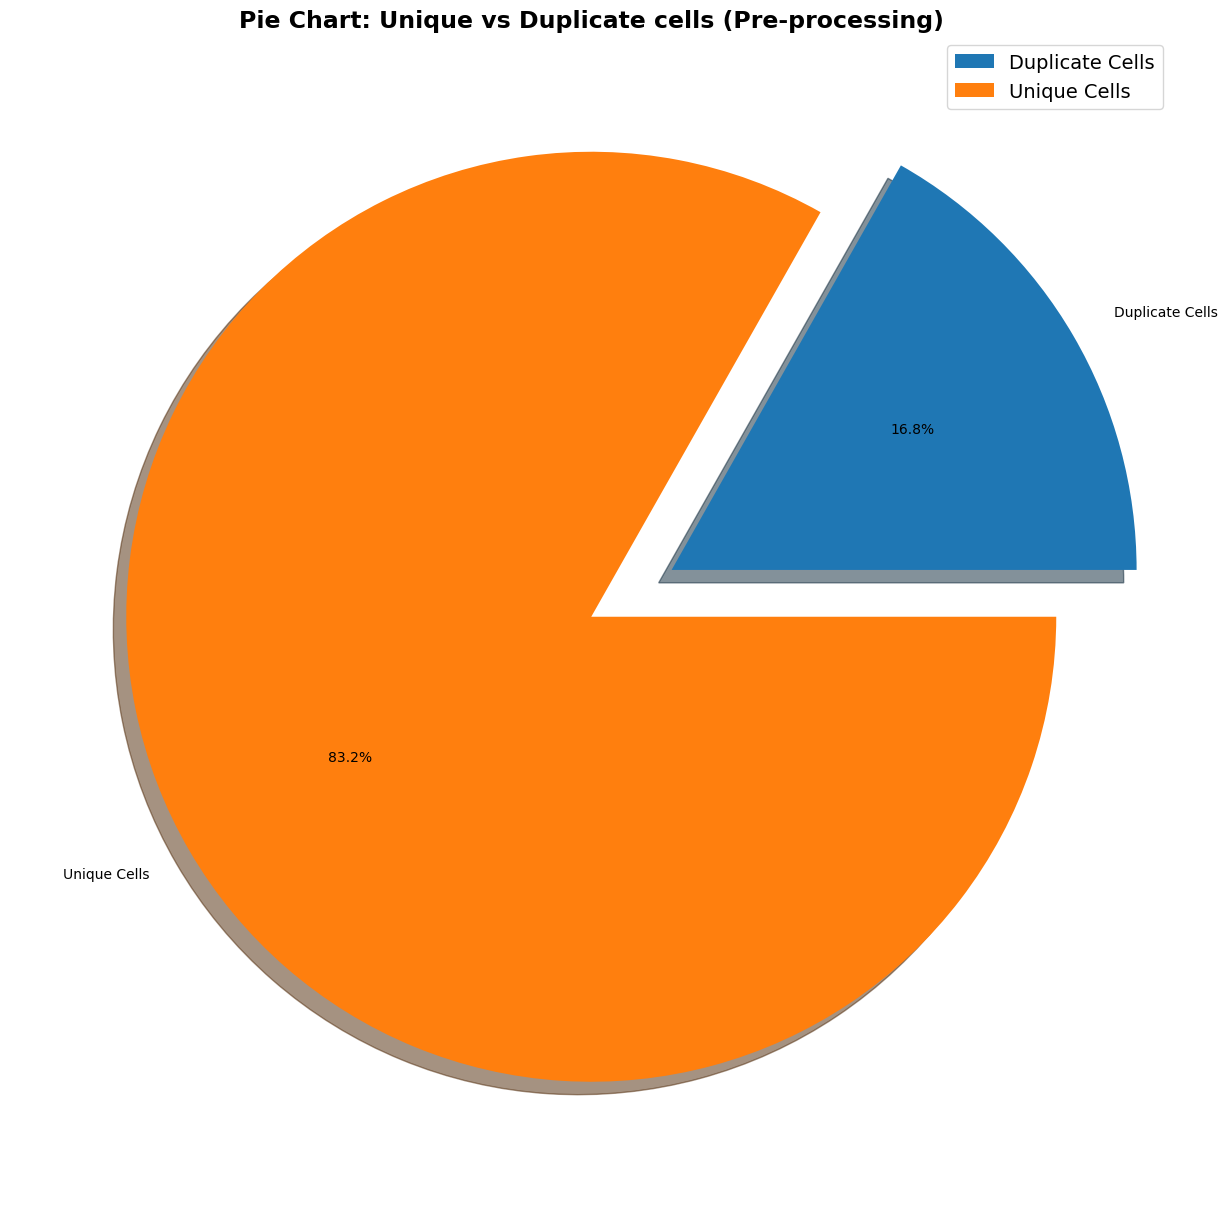

In [27]:
plt.figure(figsize=(15, 20))
plt.pie(data_values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title(title, fontsize=17, fontweight='bold')
plt.axis('off')
plt.legend(fontsize="14", loc="upper right")
plt.show()

In [28]:
merged_df = merged_df.drop_duplicates(subset=None, keep='first', inplace=False,
                                                    ignore_index=False)

In [29]:
duplicated_cells = 0
check_duplicate = merged_df.duplicated()

for row in check_duplicate:
    if row:
        duplicated_cells += 1

print("• Number of duplicated cells after de-duplication:", duplicated_cells)

• Number of duplicated cells after de-duplication: 0


In [30]:
data_values = np.array([duplicated_cells, len(merged_df) - duplicated_cells])
explode = [0.2, 0]
labels = ["Duplicate Cells", "Unique Cells"]
title = "Pie Chart: Unique vs Duplicate cells (Post-processing)"

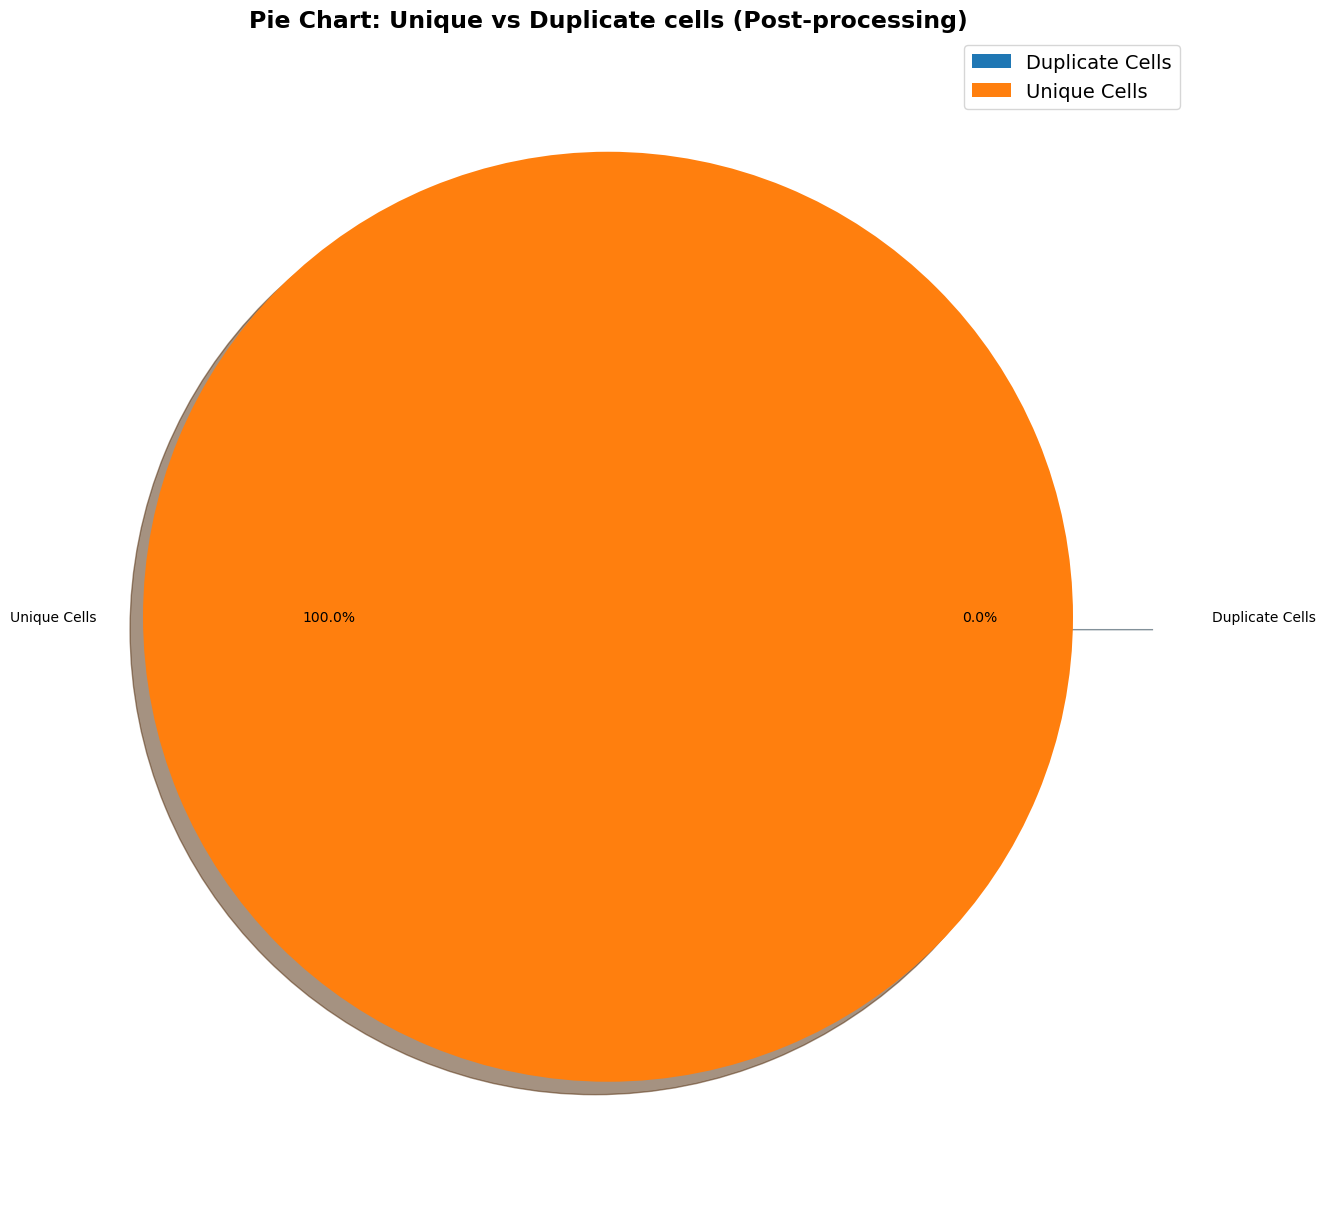

In [31]:
plt.figure(figsize=(15, 20))
plt.pie(data_values, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title(title, fontsize=17, fontweight='bold')
plt.axis('off')
plt.legend(fontsize="14", loc="upper right")
plt.show()

In [32]:
# Games Rating

In [33]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473128 entries, 0 to 568985
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Rating        473128 non-null  float64
 1   Verified      473128 non-null  bool   
 2   asin          473128 non-null  object 
 3   reviewerName  473128 non-null  object 
 4   ReviewText    473128 non-null  object 
 5   Summary       473128 non-null  object 
 6   Title         473128 non-null  object 
 7   Brand         473128 non-null  object 
 8   Category      473128 non-null  object 
dtypes: bool(1), float64(1), object(7)
memory usage: 32.9+ MB


In [34]:
bins = 15
d1 = merged_df['Rating']

Text(0.5, 1.0, 'Histogram: Book Ratings')

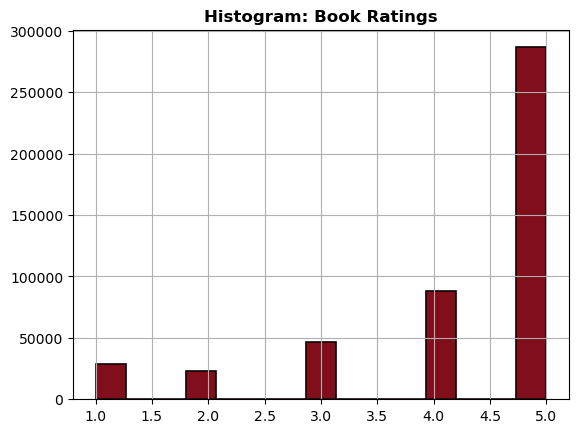

In [35]:
fig, axes = plt.subplots(1, 1)
plt.rcParams["figure.figsize"] = [14, 8]


d1.hist(bins=bins, color='#800e1b',  edgecolor='#0d0103', linewidth=1.2)

axes.set_title('Histogram: Book Ratings', fontsize=12, fontweight='bold')

## Top 10 Brands?Company

In [36]:
text = "Pie Distribution: Top Companies in terms of Sales"
genre = merged_df['Brand'].value_counts().sort_values(ascending=False)
genre = genre.head(10)
genre

        Nintendo           44105
        Electronic Arts    38588
        Sony               34567
        Microsoft          26826
        Ubisoft            24500
        Activision         23180
        Square Enix        13602
        Capcom             11180
        WB Games           10632
        Sega                9488
Name: Brand, dtype: int64

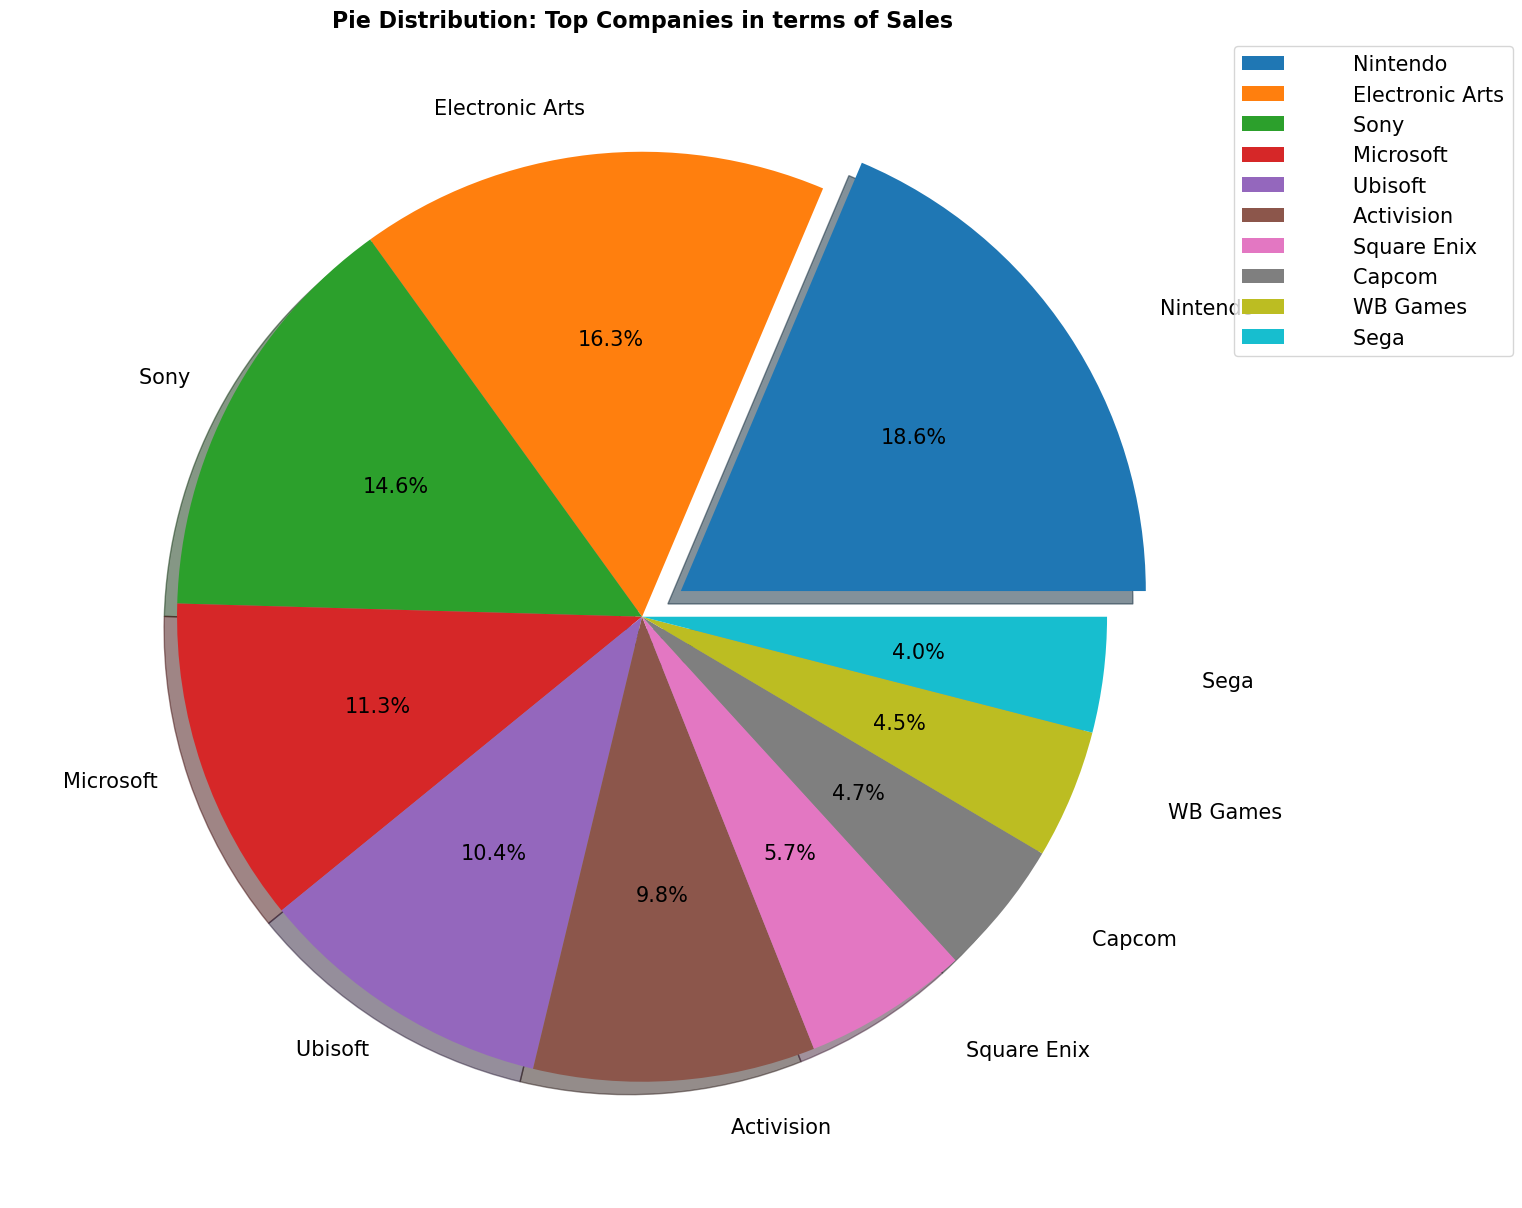

In [37]:
plt.figure(figsize=(15, 20))
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)
labels = genre.keys().map(str)

try:
    plt.pie(genre, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, textprops={'fontsize': 15})

except Exception as exc:
    print("! ", exc)

else:
    plt.title(text, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=15)
    plt.show()

In [38]:
most_purchases = merged_df.groupby('Title')['reviewerName'].count().sort_values()
df_temp_rating = most_purchases.to_frame()
df_temp_rating['most_purchases'] = most_purchases
df_arg = df_temp_rating['most_purchases'].sort_values(ascending=False)
df_arg.head(20)


Title
Diablo III                                                            964
The Last of Us Remastered - PlayStation 4                             781
Xbox 360 Wireless Controller - Glossy Black                           694
Uncharted 4: A Thief's End - PlayStation 4                            683
Assassin's Creed - Playstation 3                                      656
Wii                                                                   629
Halo 4 - Xbox 360 (Standard Game)                                     623
Assassin's Creed                                                      622
Mario Kart 8 - Nintendo Wii U                                         607
Bloodborne                                                            572
Xbox 360 LIVE 1600 Points                                             562
Fallout 4 - PlayStation 4                                             559
Xbox One Play and Charge Kit                                          558
Destiny - Standard Edition - Pla

In [39]:
top_100_titles = df_arg.head(300).index
filtered_df = merged_df[merged_df['Title'].isin(top_100_titles)]

In [40]:
most_purchases = filtered_df.groupby('Title')['reviewerName'].count().sort_values()
df_temp_rating = most_purchases.to_frame()
df_temp_rating['most_purchases'] = most_purchases
df_arg = df_temp_rating['most_purchases'].sort_values(ascending=False)
df_arg.head(20)

Title
Diablo III                                                            964
The Last of Us Remastered - PlayStation 4                             781
Xbox 360 Wireless Controller - Glossy Black                           694
Uncharted 4: A Thief's End - PlayStation 4                            683
Assassin's Creed - Playstation 3                                      656
Wii                                                                   629
Halo 4 - Xbox 360 (Standard Game)                                     623
Assassin's Creed                                                      622
Mario Kart 8 - Nintendo Wii U                                         607
Bloodborne                                                            572
Xbox 360 LIVE 1600 Points                                             562
Fallout 4 - PlayStation 4                                             559
Xbox One Play and Charge Kit                                          558
Destiny - Standard Edition - Pla

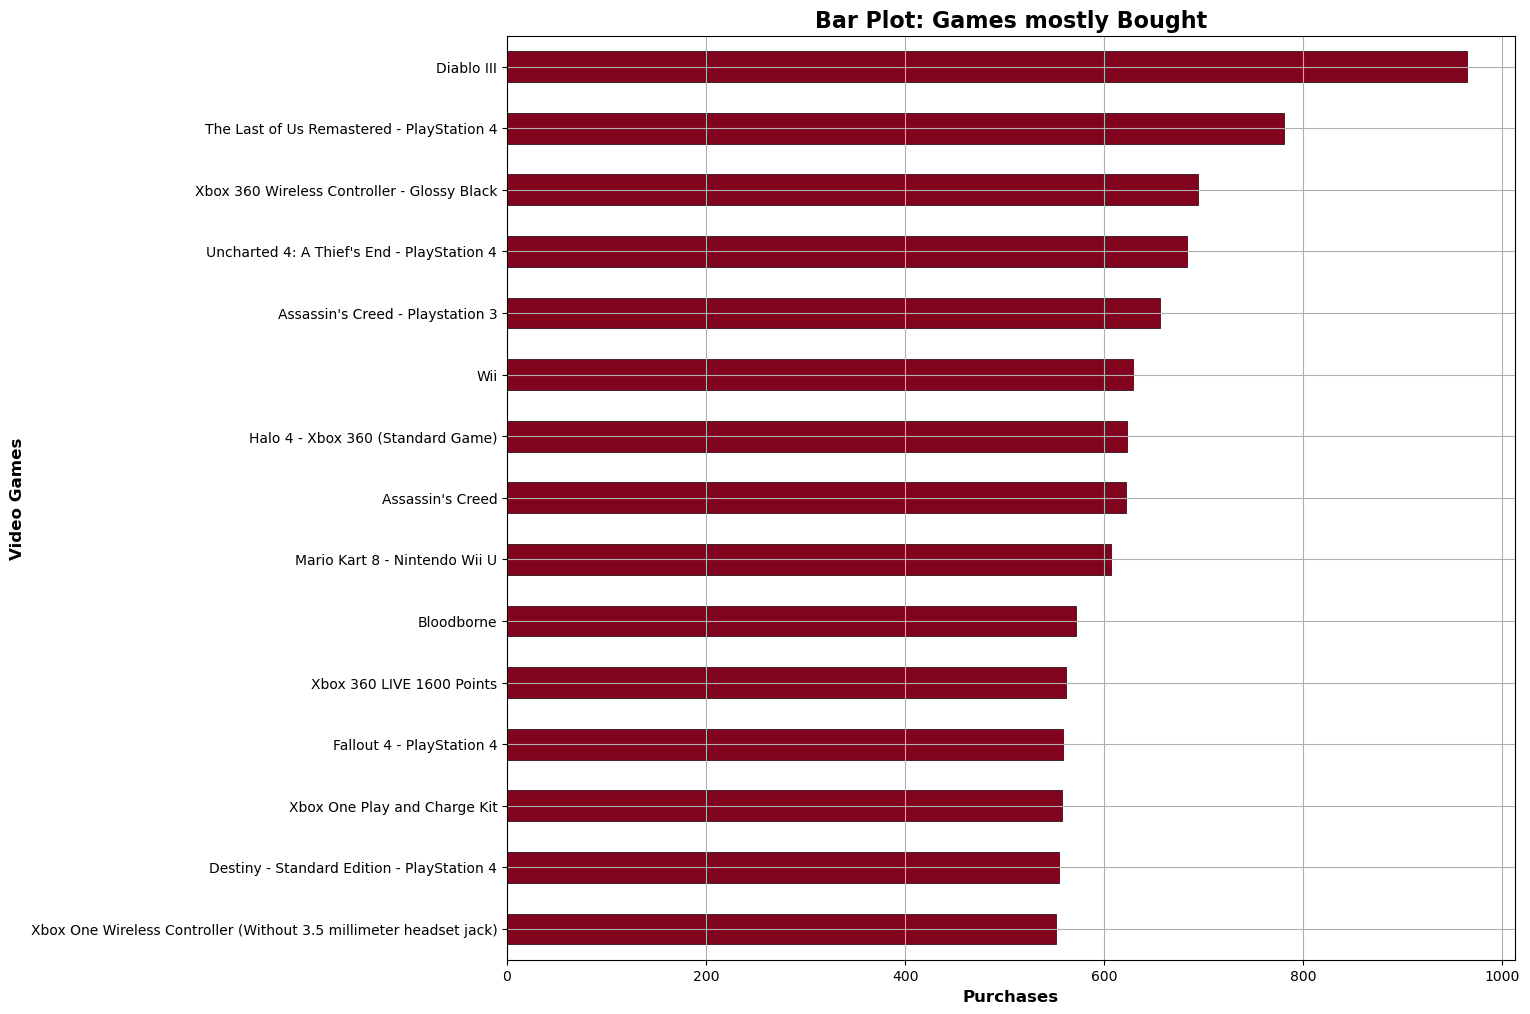

In [41]:
text = "Bar Plot: Games mostly Bought"
x_label = "Purchases"
y_label = "Video Games"
most_purchases[-15:].plot(kind='barh', figsize=(13, 12), color='#82031e', edgecolor='#0d0103', linewidth=0.5)
plt.title(text, fontsize=16, fontweight='bold')
plt.xlabel(x_label, fontsize=12, fontweight='bold')
plt.ylabel(y_label, fontsize=12, fontweight='bold')
plt.grid()
plt.show()

In [42]:
highest_rated = filtered_df.groupby('Title')['Rating'].mean()
df_temp_rating = highest_rated.to_frame()
df_temp_rating['mean_ratings'] = highest_rated
df_temp_rating['mean_ratings']

Title
 Call of Duty                                                           3.009569
 Castlevania                                                            4.294355
 Gran Turismo 5 - Playstation 3                                         4.083770
 Halo 3                                                                 3.864964
 Mass Effect 2 Platinum Hits                                            4.584906
                                                                          ...   
Yoshi amiibo (Super Smash Bros Series)                                  4.752768
Zettaguard Wireless PC USB Gaming Receiver for Xbox 360 Compact Disc    4.132143
inFAMOUS - Playstation 3                                                4.461538
inFAMOUS: Second Son Limited Edition (PlayStation 4)                    4.429134
inFAMOUS: Second Son Standard Edition (PlayStation 4)                   4.388102
Name: mean_ratings, Length: 300, dtype: float64

In [43]:
df_arg = df_temp_rating['mean_ratings'].sort_values(ascending=False)
df_arg

Title
Chrono Trigger                                                                      4.828947
PlayStation 3 Dualshock 3 Wireless Controller (Urban Camouflage) - Playstation 3    4.812183
Fire Emblem: Awakening                                                              4.810345
Nintendo Wii Remote Plus - White                                                    4.808511
The Legend of Zelda: Ocarina of Time                                                4.802083
                                                                                      ...   
No Man's Sky - PlayStation 4                                                        2.905759
Star Wars: Battlefront - Standard Edition - PlayStation 4                           2.903485
Street Fighter V - PlayStation 4 Standard Edition                                   2.801724
SimCity [Instant Access]                                                            2.323671
SimCity: Limited Edition                                        

In [44]:
text = "Bar Plot: Highest Rated Books"
x_label = "Ratings"
y_label = "Games"

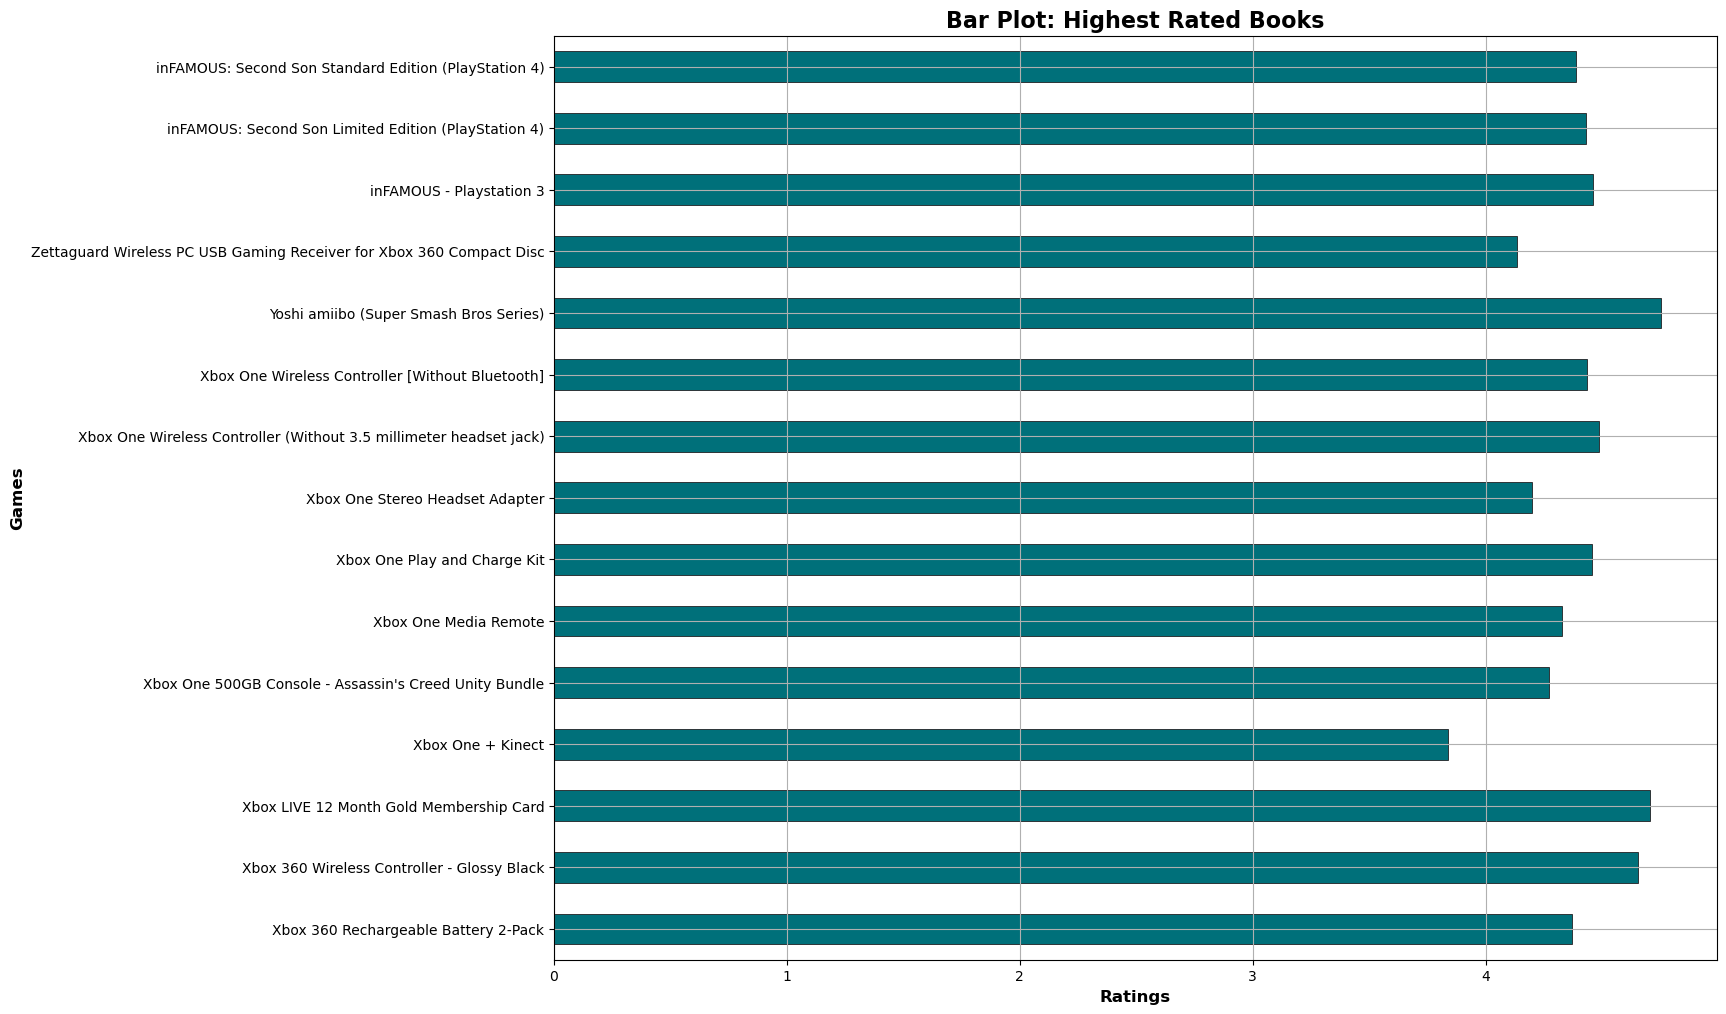

In [45]:
highest_rated[-15:].plot(kind='barh', figsize=(15, 12), color='#00707a', edgecolor='#0d0103', linewidth=0.5)
plt.title(text, fontsize=16, fontweight='bold')
plt.xlabel(x_label, fontsize=12, fontweight='bold')
plt.ylabel(y_label, fontsize=12, fontweight='bold')
plt.grid()
plt.show()

# Colaborative Filtering

In [46]:
import re

In [47]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader


from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split




In [48]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92260 entries, 573 to 564485
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rating        92260 non-null  float64
 1   Verified      92260 non-null  bool   
 2   asin          92260 non-null  object 
 3   reviewerName  92260 non-null  object 
 4   ReviewText    92260 non-null  object 
 5   Summary       92260 non-null  object 
 6   Title         92260 non-null  object 
 7   Brand         92260 non-null  object 
 8   Category      92260 non-null  object 
dtypes: bool(1), float64(1), object(7)
memory usage: 6.4+ MB


In [49]:


#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(filtered_df[['reviewerName', 'Title', 'Rating']], reader)



In [50]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [51]:
filtered_df.head(10)

,Rating,Verified,asin,reviewerName,ReviewText,Summary,Title,Brand,Category
573,2.0,False,B000006RGS,G. Hollis,I'm going to fly in the face of convention wis...,"Concept is good, but tedious game play really ...",Tomb Raider,Unknown,Books
574,5.0,False,B000006RGS,MacArthur Davis,Ive had Tomb raider since July and this game i...,Just buy it,Tomb Raider,Unknown,Books
575,5.0,False,B000006RGS,Ronald Hogan,This is the best game I have yet to play. It ...,The standard for game design.,Tomb Raider,Unknown,Books
576,5.0,False,B000006RGS,John Phelps,Went back and played this again.\nGood but it ...,Good but it has REALLY aged,Tomb Raider,Unknown,Books
577,5.0,False,B000006RGS,Alan C. Logan,This is the best Tomb Raider along with the 2n...,original tomb raider is awesome,Tomb Raider,Unknown,Books
578,5.0,True,B000006RGS,JDUB,Thanks,Five Stars,Tomb Raider,Unknown,Books
579,5.0,True,B000006RGS,Aaron Chromoy,a+,Five Stars,Tomb Raider,Unknown,Books
580,5.0,False,B000006RGS,Chris leigh,This is an amazing oringal game that I purely ...,True Oringal PlayStation Classic!,Tomb Raider,Unknown,Books
581,5.0,True,B000006RGS,suzanne palmer,it was just as described,Five Stars,Tomb Raider,Unknown,Books
582,5.0,True,B000006RGS,Mahmood,"Thanks a lot, It's a great product & service",Perfect,Tomb Raider,Unknown,Books


In [52]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [53]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [54]:
test_pred

[Prediction(uid='C. Nguyen', iid='Microsoft Xbox 360 Wireless Receiver for Windows', r_ui=5.0, est=1.9949183353600421, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='Raykim98', iid='Metal Gear Solid HD Collection', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='Xinra', iid='Nintendo 3DS Compatible with 3DS / 3DS XL / 2DS AC Adapter', r_ui=5.0, est=4.400462717285569, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(uid='Alfred Cavazos', iid='Resistance: Fall of Man - Playstation 3', r_ui=5.0, est=4.335077885478926, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='spence3338', iid='God of War III - Playstation 3', r_ui=5.0, est=4.776854296666345, details={'actual_k': 3, 'was_impossible': False}),
 Prediction(uid='Terrell E. Brooks', iid='Pok&eacute;mon Omega Ruby - Nintendo 3DS', r_ui=5.0, est=3.7967302684936186, details={'actual_k': 1, 'was_impossible': False}),
 Predict

In [55]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1212


1.1211888393138132

In [56]:
new_df1=filtered_df.head(100000)
ratings_matrix = new_df1.pivot_table(values='Rating', index='reviewerName', columns='Title', fill_value=0)
ratings_matrix.head()

Title,Call of Duty,Castlevania,Gran Turismo 5 - Playstation 3,Halo 3,Mass Effect 2 Platinum Hits,The Sims 3 - PC,16GB PlayStation Vita Memory Card,32GB PlayStation Vita Memory Card,60GB Hard Disk Drive for Xbox 360 Slim,"AmazonBasics Carrying Case for Nintendo - New 3DS XL, 3DS XL - Red (Officially Licensed by Nintendo)",...,Xbox One Media Remote,Xbox One Play and Charge Kit,Xbox One Stereo Headset Adapter,Xbox One Wireless Controller (Without 3.5 millimeter headset jack),Xbox One Wireless Controller [Without Bluetooth],Yoshi amiibo (Super Smash Bros Series),Zettaguard Wireless PC USB Gaming Receiver for Xbox 360 Compact Disc,inFAMOUS - Playstation 3,inFAMOUS: Second Son Limited Edition (PlayStation 4),inFAMOUS: Second Son Standard Edition (PlayStation 4)
reviewerName,,,,,,,,,,,,,,,,,,,,,
/ King Mecha Sigma,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Boo,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Funkykong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GrandpaJake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Oreo Cookie Chocolate Peanut Butter Pie 2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
ratings_matrix.shape

(31185, 300)

In [58]:
X = ratings_matrix.T
X.head(100)

reviewerName,/ King Mecha Sigma,Boo,Funkykong,GrandpaJake,Oreo Cookie Chocolate Peanut Butter Pie 2018,#1 gamer ever,#Infinity,#amazonaddict,&#039;&#039;Yous&#039;&#039;,&#039;J&#039; Willys,...,zookatooya,zorabelle,ztoben,zx2781,zyphlus,~AudioBookaHolic~,~Awful Good Reviews~,~Miss~,~pw,~~LA
Title,,,,,,,,,,,,,,,,,,,,,
Call of Duty,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Castlevania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Gran Turismo 5 - Playstation 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Halo 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mass Effect 2 Platinum Hits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gears of War 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
God of War - PlayStation 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
God of War III - Playstation 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X.shape

(300, 31185)

In [60]:
X1 = X

In [61]:
#Decomposing the Matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(300, 10)

In [62]:
#Correlation Matrix

correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(300, 300)

In [63]:


X.index[35]



'BioShock Infinite - PS3 [Digital Code]'

In [64]:
i = "BioShock Infinite - PS3 [Digital Code]"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

35

In [65]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(300,)

In [66]:


Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:10]



[' Call of Duty',
 ' Castlevania',
 ' Gran Turismo 5 - Playstation 3',
 ' The Sims 3 - PC',
 '16GB PlayStation Vita Memory Card',
 '32GB PlayStation Vita Memory Card',
 '60GB Hard Disk Drive for Xbox 360 Slim',
 'AmazonBasics Carrying Case for Nintendo - New 3DS XL, 3DS XL - Red (Officially Licensed by Nintendo)',
 "Assassin's Creed - Playstation 3",
 "Assassin's Creed II - Greatest Hits edition - Playstation 3"]

# Content Based Filtering

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


# Content-Based Filtering using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)  # Adjust the value as needed
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_df['ReviewText'])


from sklearn.decomposition import IncrementalPCA

chunk_size = 1000
for i in range(0, len(filtered_df), chunk_size):
    chunk = filtered_df['ReviewText'].iloc[i:i+chunk_size]
    tfidf_matrix_chunk = tfidf_vectorizer.transform(chunk)
    cosine_sim_chunk = linear_kernel(tfidf_matrix_chunk, tfidf_matrix)
    print(cosine_sim_chunk)

# Hybrid Approaches
### Combine collaborative filtering and content-based filtering to take advantage of the strengths of both approaches.

In [71]:
def get_content_based_recommendations(title):
    # Placeholder for content-based recommendation logic
    # Replace this with your actual content-based recommendation code
    content_based_recommendations = ['Movie1', 'Movie2', 'Movie3']
    return content_based_recommendations

In [90]:
def hybrid_recommendation(reviewerName, Title, alpha=0.5):
    # Use collaborative filtering to get top-N recommendations
    user_item_cf = algo.predict(reviewerName, Title).est

    # Use content-based filtering to get top-N recommendations
    content_based_recommendations = get_content_based_recommendations(Title)

    # Convert content-based recommendations to a numeric format (example: length of the list)
    content_based_recommendations_numeric = len(content_based_recommendations)

    # Combine results (e.g., weighted average)
    hybrid_recommendations = alpha * user_item_cf + (1 - alpha) * content_based_recommendations_numeric

    # Return or display the final hybrid recommendations
    return hybrid_recommendations

# Example usage
user_id = 'John Phelps'
item_id = 'The Legend of Zelda: Ocarina of Tim'
alpha_value = 0.7  # Adjust the alpha value as needed
hybrid_result = hybrid_recommendation(reviewerName, Title, alpha=0.5)

print("Hybrid Recommendations:", hybrid_result)


Hybrid Recommendations: 3.667538942739463


In [88]:
filtered_df.head(200)

,Rating,Verified,asin,reviewerName,ReviewText,Summary,Title,Brand,Category
573,2.0,False,B000006RGS,G. Hollis,I'm going to fly in the face of convention wis...,"Concept is good, but tedious game play really ...",Tomb Raider,Unknown,Books
574,5.0,False,B000006RGS,MacArthur Davis,Ive had Tomb raider since July and this game i...,Just buy it,Tomb Raider,Unknown,Books
575,5.0,False,B000006RGS,Ronald Hogan,This is the best game I have yet to play. It ...,The standard for game design.,Tomb Raider,Unknown,Books
576,5.0,False,B000006RGS,John Phelps,Went back and played this again.\nGood but it ...,Good but it has REALLY aged,Tomb Raider,Unknown,Books
577,5.0,False,B000006RGS,Alan C. Logan,This is the best Tomb Raider along with the 2n...,original tomb raider is awesome,Tomb Raider,Unknown,Books
...,...,...,...,...,...,...,...,...,...
1114,4.0,False,B00000DMB3,A. Vegan,I was always a fan of Zelda when it first came...,Pretty Challenging,The Legend of Zelda: Ocarina of Time,Nintendo,Video Games
1115,5.0,False,B00000DMB3,Nick Watkins,This game is truly phenonemonal. From the amaz...,The Best Game...Ever...,The Legend of Zelda: Ocarina of Time,Nintendo,Video Games
1116,5.0,False,B00000DMB3,Sylvia P. Doukas,"Thinking back on the times of Zelda, have got ...",I will Remember the Magic,The Legend of Zelda: Ocarina of Time,Nintendo,Video Games
1117,5.0,False,B00000DMB3,Cloud,Reading magazines from 1996-1998 one thing you...,One of the most critically acclaimed games ever,The Legend of Zelda: Ocarina of Time,Nintendo,Video Games


In [85]:
 print(hybrid_recommendation)

<function hybrid_recommendation at 0x00000247B45EF1F0>


In [86]:
reviewerName = 'Ronald Hogan'
Title = 'Tomb Raider'
hybrid_result = hybrid_recommendation(reviewerName, Title)

print("Hybrid Recommendations:", hybrid_result)

Hybrid Recommendations: 3.667538942739463


In [ ]:
import spacy
import pandas as pd

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Assuming 'ReviewText' is the column containing the text of the reviews
reviews = filtered_df['ReviewText']

# Function to perform NER on a given text
def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Create a copy of the DataFrame subset
filtered_df1 = filtered_df.copy()

# Apply NER to each review
filtered_df1['NER_Entities'] = reviews.apply(perform_ner)

# Display the DataFrame with NER results
print(filtered_df1[['ReviewText', 'NER_Entities']])